# Classification with Logistic Regression

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely.geometry
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

# Load NUTS Regions

In [3]:
nuts_level = 3
nuts_filepath = "data/nuts_60m.gpkg"

# Load NUTS regions
gdf_nuts = gpd.read_file(
    nuts_filepath, 
    ignore_fields=['name_latn', 'nuts_name', 'population'],
    driver='GPKG')
gdf_nuts = gdf_nuts.rename(
    columns={'cntr_code': 'country'})

# Filter by NUTS level and extent
EXTENT = [-19.6,32.9,47.7,72.2]  # Europe without colonies
mask = (gdf_nuts['levl_code'] == nuts_level) \
     & gdf_nuts.within(shapely.geometry.box(*EXTENT))
gdf_nuts = gdf_nuts[mask]

gdf_nuts.head(2)

,nuts_id,levl_code,country,geometry
471,AT111,3,AT,"MULTIPOLYGON (((16.64600 47.44700, 16.43400 47..."
472,AT112,3,AT,"MULTIPOLYGON (((17.16100 48.00700, 17.09300 47..."


# Load Normalized Amenity Features

In [4]:
features_filepath = "data/europe-amenity-features.csv.gz"

# Load features and fill missing values with 0
df_features = pd.read_csv(features_filepath).fillna(0)

# Filter by NUTS level
nuts_ids = gdf_nuts['nuts_id'].values
mask = df_features['nuts_id'].isin(nuts_ids)
df_features = df_features[mask]

df_features.head(2)

,nuts_id,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,...,car_wash,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre
3,AL011,0.000345,0.000000,0.000216,0.000233,0.000570,0.000000,0.000406,0.0,0.000345,...,0.000035,0.000017,0.000009,0.0,0.0,0.000000,0.0,0.0,0.0,0.000017
4,AL012,0.000275,0.000031,0.000096,0.000196,0.000093,0.000007,0.000519,0.0,0.000107,...,0.000031,0.000007,0.000024,0.0,0.0,0.000003,0.0,0.0,0.0,0.000000


# Prepare Data

In [5]:
# number of amenity features (max 50)
n_features = 10
# Countries to compare
country_1 = 'DE'
country_2 = 'FR'

df = pd.merge(gdf_nuts[['nuts_id', 'country']], df_features, 
              on='nuts_id', how='left').fillna(0)
df_selection = df[df['country'].isin([country_1, country_2])]

X = df_selection.drop(columns=['nuts_id', 'country']).values[:, :n_features]
y = df_selection['country'].map({country_1: 0, country_2: 1}).values

# Train Classifier

Documentation:

- [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [sklearn.linear_model.LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1000, stratify=y)

# Train logistic regression
clf = LogisticRegressionCV(cv=5)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=5)

# Test Classifier

In [7]:
print('Training score : {:.4f}'.format(clf.score(X_train, y_train)))
print('Testing score  : {:.4f}'.format(clf.score(X_test, y_test)))

Training score : 0.8519
Testing score  : 0.8418


# Classify Data

In [8]:
column_name = f"{country_1}-{country_2}"

s_classification = df.drop(columns=['nuts_id', 'country']).iloc[:, :n_features].apply(
    lambda row: clf.predict_proba([row.values])[:, 1][0], axis=1)
s_classification.name = column_name
df_classification = df[['nuts_id']].join(s_classification)
df_classification.head(2)

,nuts_id,DE-FR
0,AT111,0.328196
1,AT112,0.094822


# Visualize Data

Brighter regions are more similar to first country, darker regions are more similar to second country.

- [GeoPandas - Mapping and Plotting Tools](https://geopandas.org/docs/user_guide/mapping.html)

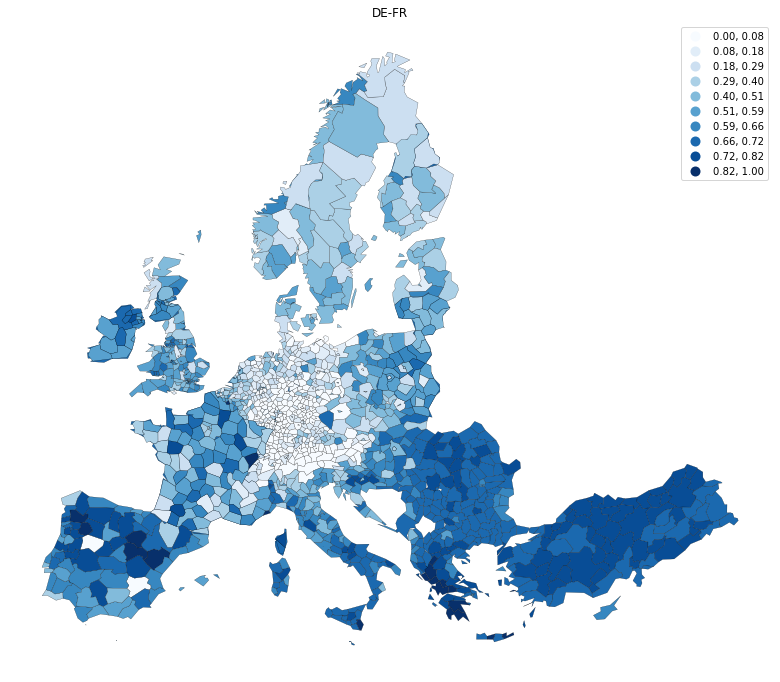

In [9]:
gdf_classification = pd.merge(
    gdf_nuts, df_classification, 
    on='nuts_id', how='right')

fig, ax = plt.subplots(figsize=(16, 12))

gdf_classification.to_crs(epsg='3035').plot(
    ax=ax,
    column=column_name,
    cmap='Blues',
    legend=True,
    linewidth=0.2,
    scheme='natural_breaks',
    k=10,
    edgecolor='k');
ax.set_title(column_name)
ax.set_axis_off();

# Resources

- [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [sklearn.linear_model.LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)
- [GeoPandas - Mapping and Plotting Tools](https://geopandas.org/docs/user_guide/mapping.html)